# Benchmarking the first and second orders propagator with the exact propagator calculated via matrix exponential

Interestingly, the **results depend on the boundary conditions**. <strike>The second order is indeed more accurate than the first order for periodic boundary conditions, whereas there is **no significant difference between the first and second order Skolem propagators for open boundary conditions.**</strike>

In [1]:
import os

threads = 1
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
import time
import numpy as np
from scipy.linalg import norm, expm
import matplotlib.pyplot as plt

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis

from skolem_propagator_bose_hubbard import BHSkolemPropagator as BHSkolemPropagator_1ord
from second_ord_skolem_propagator_bose_hubbard import BHSkolemPropagator as BHSkolemPropagator_2ord

## Parameters of the $K$ sites Bose Hubbard model and propagation

In [3]:
bh_params = dict(
    # On-sight interaction
    U = 10,
    
    # Hopping energy
    J = 1,
    
    # Chemical potential
    mu = 0,
    
    # Number of bosons
    N = 30,
    
    # Number of sites
    K = 3,
    
    # time-step
    dt = 0.001
)

times = bh_params['dt'] * np.arange(100)

##  QuSpin

Comparing the implementation of the Bose-Hubbard Model in the QuSpin library by following: https://github.com/weinbe58/QuSpin/blob/master/examples/notebooks/BHM.ipynb

In [4]:
def exact_evolve(ψ0, times, *, U, J, N, K, mu, is_pbc, **kwargs):
    
    ##### construct Bose-Hubbard Hamiltonian #####
    # define boson basis with N states per site K bosons in the lattice

    basis = boson_basis_1d(K, Nb=N) # full boson basis

    # define site-coupling lists
    if is_pbc:
        # Peridodic bouundary condition
        hop=[[-J,i,(i+1)%K] for i in range(K)] 
    else:
        # open boundary condition
        hop=[[-J,i,(i+1)%K] for i in range(K - 1)]

    interact=[[0.5*U,i,i] for i in range(K)] # U/2 \sum_j n_j n_j
    pot=[[-mu-0.5*U,i] for i in range(K)] # -(\mu + U/2) \sum_j j_n

    # define static and dynamic lists
    static=[['+-',hop],['-+',hop],['n',pot],['nn',interact]]
    dynamic=[]

    # build Hamiltonian
    H =  hamiltonian(static,dynamic,basis=basis,dtype=np.float64)
    
    dt = times[1] - times[0]
    
    # Get the exact unitary propagator  
    U = expm(-1j * dt * H.toarray())
    
    Ψ = [ψ0,]
    
    for _ in times[1:]:
        Ψ.append(
            U @ Ψ[-1]
        )
    
    Ψ = np.array(Ψ).T
    
    return Ψ

### Initialize Skolem propagators for the first and second orders

In [5]:
t0 = time.time()

skolem_method_1ord = BHSkolemPropagator_1ord(**bh_params)

# Save time it took to initialize the Skolem propagator 
time_prepare_skolem_1ord = time.time() - t0

t0 = time.time()

skolem_method_2ord = BHSkolemPropagator_2ord(**bh_params)

# Save time it took to initialize the Skolem propagator 
time_prepare_skolem_2ord = time.time() - t0

### Initial condition

In [6]:
ψ0 = np.zeros(skolem_method_1ord.indx.size, complex)
ψ0[0] = 1

## Open boundary condition

### Exact evolution via QuSpin

In [7]:
t0 = time.time()

Ψ_exact_obc = exact_evolve(ψ0, times, is_pbc=False, **bh_params)

print("QuSpin run time {:.1f} s".format(time.time() - t0))

Hermiticity check passed!
Particle conservation check passed!


/home/denys/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.boson.boson_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian


QuSpin run time 0.7 s


### The first order Skolem evolution

In [8]:
t0 = time.time()

Ψ_skolem_obc_1ord = [ψ0,]

for _ in times[1:]:
    Ψ_skolem_obc_1ord.append(
        skolem_method_1ord.propagate(Ψ_skolem_obc_1ord[-1], is_pbc=False)
    )
    
Ψ_skolem_obc_1ord = np.array(Ψ_skolem_obc_1ord).T

time_propagate_skolem_1ord = time.time() - t0

print("Preparation of basis and Skolem diagonalization: {:.1f} s".format(time_prepare_skolem_1ord))
print("Skolem propagation: {:.1f} s".format(time_propagate_skolem_1ord))

print("Total Skolem method run time {:.1f} s".format(time_propagate_skolem_1ord + time_propagate_skolem_1ord))

Preparation of basis and Skolem diagonalization: 0.1 s
Skolem propagation: 0.0 s
Total Skolem method run time 0.0 s


### The second order Skolem evolution

In [9]:
t0 = time.time()

Ψ_skolem_obc_2ord = [ψ0,]

for _ in times[1:]:
    Ψ_skolem_obc_2ord.append(
        skolem_method_2ord.propagate(Ψ_skolem_obc_2ord[-1], is_pbc=False)
    )
    
Ψ_skolem_obc_2ord = np.array(Ψ_skolem_obc_2ord).T

time_propagate_skolem_2ord = time.time() - t0

print("Preparation of basis and Skolem diagonalization: {:.1f} s".format(time_prepare_skolem_2ord))
print("Skolem propagation: {:.1f} s".format(time_propagate_skolem_2ord))

print("Total Skolem method run time {:.1f} s".format(time_propagate_skolem_2ord + time_propagate_skolem_2ord))

Preparation of basis and Skolem diagonalization: 0.0 s
Skolem propagation: 0.0 s
Total Skolem method run time 0.0 s


## Periodic boundary condition

### Exact evolution via QuSpin

In [10]:
t0 = time.time()

Ψ_exact_pbc = exact_evolve(ψ0, times, is_pbc=True, **bh_params)

print("QuSpin run time {:.1f} s".format(time.time() - t0))

Hermiticity check passed!
Particle conservation check passed!
QuSpin run time 0.2 s


/home/denys/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.boson.boson_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian


### The first order Skolem evolution

In [11]:
t0 = time.time()

Ψ_skolem_pbc_1ord = [ψ0,]

for _ in times[1:]:
    Ψ_skolem_pbc_1ord.append(
        skolem_method_1ord.propagate(Ψ_skolem_pbc_1ord[-1], is_pbc=True)
    )
    
Ψ_skolem_pbc_1ord = np.array(Ψ_skolem_pbc_1ord).T

time_propagate_skolem_1ord = time.time() - t0

print("Preparation of basis and Skolem diagonalization: {:.1f} s".format(time_prepare_skolem_1ord))
print("Skolem propagation: {:.1f} s".format(time_propagate_skolem_1ord))

print("Total Skolem method run time {:.1f} s".format(time_propagate_skolem_1ord + time_propagate_skolem_1ord))

Preparation of basis and Skolem diagonalization: 0.1 s
Skolem propagation: 0.0 s
Total Skolem method run time 0.0 s


### The second order Skolem evolution

In [12]:
t0 = time.time()

Ψ_skolem_pbc_2ord = [ψ0,]

for _ in times[1:]:
    Ψ_skolem_pbc_2ord.append(
        skolem_method_2ord.propagate(Ψ_skolem_pbc_2ord[-1], is_pbc=True)
    )
    
Ψ_skolem_pbc_2ord = np.array(Ψ_skolem_pbc_2ord).T

time_propagate_skolem_2ord = time.time() - t0

print("Preparation of basis and Skolem diagonalization: {:.1f} s".format(time_prepare_skolem_2ord))
print("Skolem propagation: {:.1f} s".format(time_propagate_skolem_2ord))

print("Total Skolem method run time {:.1f} s".format(time_propagate_skolem_2ord + time_propagate_skolem_2ord))

Preparation of basis and Skolem diagonalization: 0.0 s
Skolem propagation: 0.0 s
Total Skolem method run time 0.0 s


## PLOTS

### PERIODIC boundary condition: Norm difference between exact and Skolem propagator

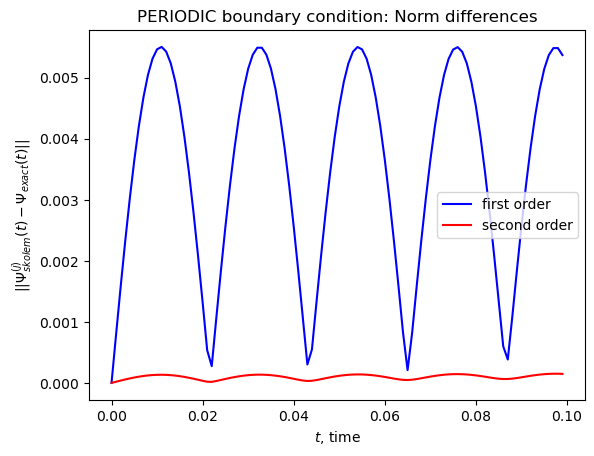

In [13]:
plt.title("PERIODIC boundary condition: Norm differences")
plt.plot(times, norm(Ψ_skolem_pbc_1ord - Ψ_exact_pbc, axis=0), label=r"first order", color = 'blue')
plt.plot(times, norm(Ψ_skolem_pbc_2ord - Ψ_exact_pbc, axis=0), label=r"second order", color = 'red')
plt.xlabel("$t$, time")
plt.ylabel(r"$\|\|\Psi_{skolem}^{(j)}(t) - \Psi_{exact}(t)\|\|$")
plt.legend()
plt.savefig('PERIODIC_1st_2nd.png')
plt.show()

### OPEN boundary condition: Norm difference between exact and Skolem propagators of 1st and 2nd order

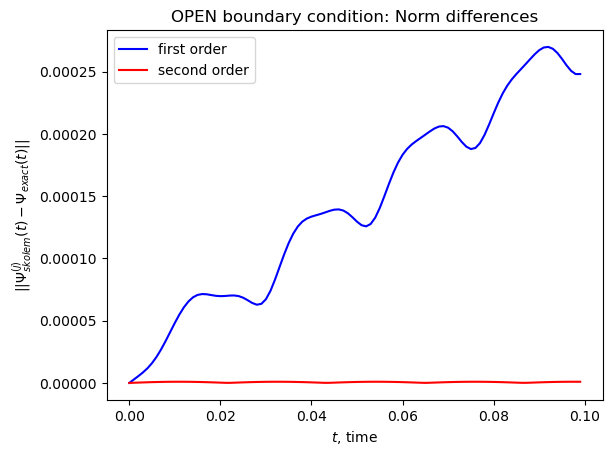

In [14]:
plt.title("OPEN boundary condition: Norm differences")
plt.plot(times, norm(Ψ_skolem_obc_1ord - Ψ_exact_obc, axis=0), label=r"first order", color = 'blue')
plt.plot(times, norm(Ψ_skolem_obc_2ord - Ψ_exact_obc, axis=0), label=r"second order", color = 'red')
plt.xlabel("$t$, time")
plt.ylabel(r"$\|\|\Psi_{skolem}^{(j)}(t) - \Psi_{exact}(t)\|\|$")
plt.legend()
#plt.show()
plt.savefig('OPEN_1st_2nd.png')
plt.show()

### Periodic boundary condition: rescaled with dt and dt^2

In [15]:
rescaleFactor = norm(Ψ_skolem_pbc_2ord - Ψ_exact_pbc, axis=0)[-1] / bh_params['dt'] /(norm(Ψ_skolem_pbc_1ord - Ψ_exact_pbc, axis=0)[-1])

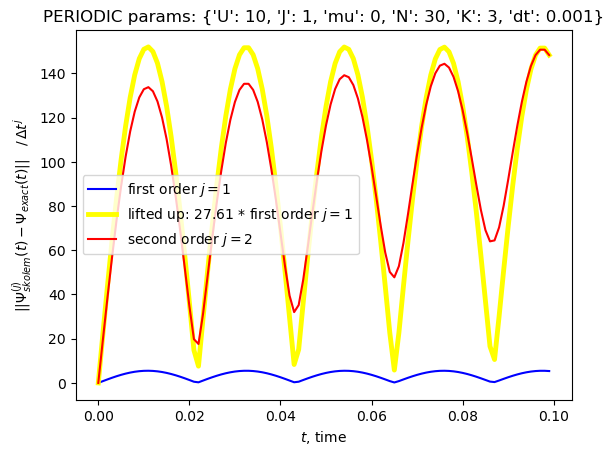

In [16]:
plt.title("PERIODIC params: %s" % (str(bh_params)))
plt.plot(times, norm(Ψ_skolem_pbc_1ord - Ψ_exact_pbc, axis=0) / bh_params['dt'] , label=r"first order $j=1$", color = 'blue')
plt.plot(times, rescaleFactor *  norm(Ψ_skolem_pbc_1ord - Ψ_exact_pbc, axis=0) / bh_params['dt'] ,linewidth=3.5 , color = 'yellow', label=r"lifted up: %.2f * first order $j=1$" % rescaleFactor)
plt.plot(times, norm(Ψ_skolem_pbc_2ord - Ψ_exact_pbc, axis=0) / bh_params['dt'] ** 2, label=r"second order $j=2$", color = 'red')
plt.xlabel("$t$, time")
plt.ylabel(r"$\|\|\Psi_{skolem}^{(j)}(t) - \Psi_{exact}(t)\|\| \quad / \, \Delta t^{j}$")
plt.legend()
plt.savefig('PERIODIC_1st_2nd__RESCALED_dt.png')
plt.show()

### OPEN boundary condition: rescaled with dt and dt^2 
### Norm difference between exact and Skolem propagator

In [17]:
rescaleFactor = norm(Ψ_skolem_obc_2ord - Ψ_exact_obc, axis=0)[-1] / bh_params['dt'] /(norm(Ψ_skolem_obc_1ord - Ψ_exact_obc, axis=0)[-1])

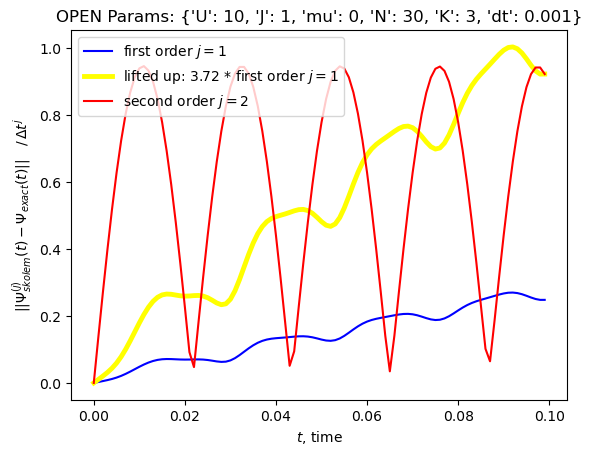

In [18]:
plt.title("OPEN Params: %s" % (str(bh_params)))
plt.plot(times, norm(Ψ_skolem_obc_1ord - Ψ_exact_obc, axis=0) / bh_params['dt'] , label=r"first order $j=1$", color = 'blue')
plt.plot(times, rescaleFactor *  norm(Ψ_skolem_obc_1ord - Ψ_exact_obc, axis=0) / bh_params['dt'] ,linewidth=3.5 , color = 'yellow', label=r"lifted up: %.2f * first order $j=1$" % rescaleFactor)
plt.plot(times, norm(Ψ_skolem_obc_2ord - Ψ_exact_obc, axis=0) / bh_params['dt'] ** 2, label=r"second order $j=2$", color = 'red')
plt.xlabel("$t$, time")
plt.ylabel(r"$\|\|\Psi_{skolem}^{(j)}(t) - \Psi_{exact}(t)\|\| \quad / \, \Delta t^{j}$")
plt.legend()
plt.savefig('OPEN_1st_2nd__RESCALED_dt.png')
plt.show()